# Questions

1. According to the Augmented Dickey-Fuller Test, are the returns stationary ?
2. Assuming that we only choose ARIMA models with p, d, q from 0 to 5, what is the optimal ARIMA order?
3. Using the given dataset, what is tomorrow’s expected return? # Date would be 09/09/2018

# Preparation

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
#import mpld3
#mpld3.enable_notebook() #for zooming in and out of the plots
rcParams['figure.figsize']= 12,6
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
orig_dataset = pd.read_csv('../input/Prices.csv')
orig_dataset.head(), orig_dataset.tail()

(       Ticker       SPY
 0  12/01/1997  68.10944
 1  12/02/1997  67.69718
 2  12/03/1997  67.89246
 3  12/04/1997  67.82737
 4  12/05/1997  68.69528,           Ticker     SPY
 7334  12/30/2017  266.86
 7335  12/31/2017  266.86
 7336  01/01/2018  266.86
 7337  01/02/2018  268.77
 7338  01/03/2018  270.47)

In [3]:
# we will just be using the period until 2017, so 10 years of data

dataset = orig_dataset[:7306]

Showing first and last five entries in the data.

- Ticker: Dates
- SPY: Prices at the given date

The dataset covers date from 12/01/1997 until 01/03/2018.

These totals to 7339 entries of the data. (rows) We will be using only until 2017.

# Data Cleaning

In [4]:
# Checking of datatypes per column
dataset.dtypes

Ticker     object
SPY       float64
dtype: object

In [5]:
# getting a hang of the dataset
dataset.describe()

,SPY
count,7306.000000
mean,118.582406
std,47.241783
min,56.588990
25%,86.147440
50%,101.486780
75%,129.317560
max,263.661980


In [6]:
# check for missing values
nulls_spy = dataset['SPY'].isnull()
np.sum(dataset[nulls_spy])

Ticker    0.0
SPY       0.0
dtype: float64

In [7]:
nulls_ticker = dataset['Ticker'].isnull()
np.sum(dataset[nulls_ticker])

Ticker    0.0
SPY       0.0
dtype: float64

Here we saw that Ticker column is an object type or a string.  We transform this into a datetime 

In [8]:
dataset['Ticker'] = pd.to_datetime(dataset.Ticker)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [9]:
# If there are zero values, we could see in least value since it's a float64 series
dataset['SPY'].min(), dataset['SPY'].max()

(56.58899, 263.66197999999997)

In [10]:
# check the range of data
dataset['Ticker'].min(), dataset['Ticker'].max()

(Timestamp('1997-12-01 00:00:00'), Timestamp('2017-12-01 00:00:00'))

Missing Values are checked. 

Dataset is checked of NaNs, zeros, and its datatype.

In [11]:
dataset.head(), dataset.tail()

(      Ticker       SPY
 0 1997-12-01  68.10944
 1 1997-12-02  67.69718
 2 1997-12-03  67.89246
 3 1997-12-04  67.82737
 4 1997-12-05  68.69528,          Ticker        SPY
 7301 2017-11-27  258.90629
 7302 2017-11-28  261.53286
 7303 2017-11-29  261.37368
 7304 2017-11-30  263.66198
 7305 2017-12-01  263.11477)

In [12]:
nulls_ticker = dataset['Ticker'].isnull()
np.sum(dataset[nulls_ticker])

Ticker    0.0
SPY       0.0
dtype: float64

In [13]:
nulls_spy = dataset['SPY'].isnull()
np.sum(dataset[nulls_spy])

Ticker    0.0
SPY       0.0
dtype: float64

# Start of Analysis

In [14]:
# set your dates as the index for each SPY value
indexed_dataset = dataset.set_index(['Ticker'])

In [15]:
# just to be sure
nulls_ticker = dataset['Ticker'].isnull()
np.sum(dataset[nulls_ticker])

Ticker    0.0
SPY       0.0
dtype: float64

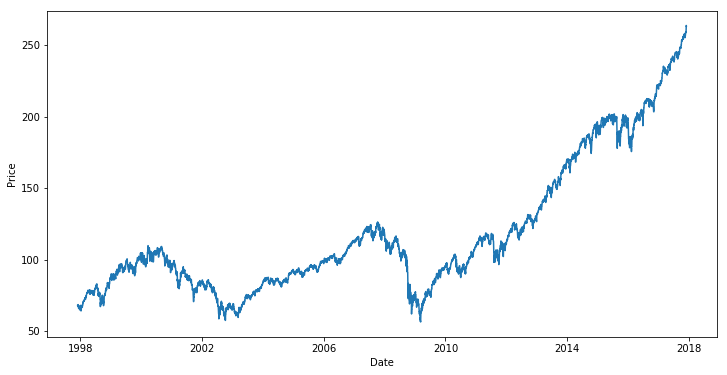

In [16]:
# plot the dataset

plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(indexed_dataset)

## Augmented Dickey-Fuller Test

We start with the ADCF test to check the stationarity of the dataset.

Hypothesis:

- The null hypothesis for this test is that the time series is not stationary.
- The alternate hypothesis is that the time series is stationary.
- p value should be lower than 0.05(optimal)
- Test statistic should be lowet than the critical values.

In [17]:
dftest = adfuller(indexed_dataset['SPY'], autolag ='AIC')

df_output = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', 'Lags', 'No. of observations'])

for key, value in dftest[4].items():
    df_output['Critical value (%s)'%key] = value
    
df_output

Test Statistic             1.900001
p-value                    0.998528
Lags                      11.000000
No. of observations     7294.000000
Critical value (1%)       -3.431247
Critical value (5%)       -2.861936
Critical value (10%)      -2.566981
dtype: float64

Conclusion from the Augmented Dickey Fuller Test:

The test statistics should be less than the critical values, we can reject the null hypothesis & say that the series is stationary. 

The data is not stationary and we fail to reject the null hypothesis which is $Hnull < p0.05$.

Test statistic is also greater than the Critical Values so we can fail to reject the null Hypothesis.

**This is not a Stationary Dataset**

We now try to make the dataset into a stationary one. We transform it into a logscale, and we save a function for adcf test everytime.

In [18]:
# save rolling means and std, and moving averages for original values
moving_average = indexed_dataset.rolling(window = 365).mean()
moving_std = indexed_dataset.rolling(window = 365).std()
rolmean = indexed_dataset.rolling(window = 365).mean()
rolstd = indexed_dataset.rolling(window = 365).std()

indexed_dataset_logscale = np.log(indexed_dataset)

In [19]:
# save moving average values in logscale

moving_average_logscale = indexed_dataset_logscale.rolling(window = 365).mean()
moving_std_logscale = indexed_dataset_logscale.rolling(window = 365).std()

In [20]:
# let's save a function for adf test
# the red line in  the graphs will be the moving averages with windows of a year.

def adf_test(timeseries):
    moving_average = timeseries.rolling(window=365).mean()
    moving_std = timeseries.rolling(window=365).std()
    
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(moving_average, color='red', label='Rolling Mean')
    std = plt.plot(moving_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling mean & Standard deviation')
    plt.show(block=False)    
    
    print('Results of Dickey Fuller Test:')
   
    adftest = adfuller(timeseries['SPY'], autolag='AIC')
    adfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in adftest[4].items():
        adfoutput['Critical Value (%s)'%key] = value
    print(adfoutput)

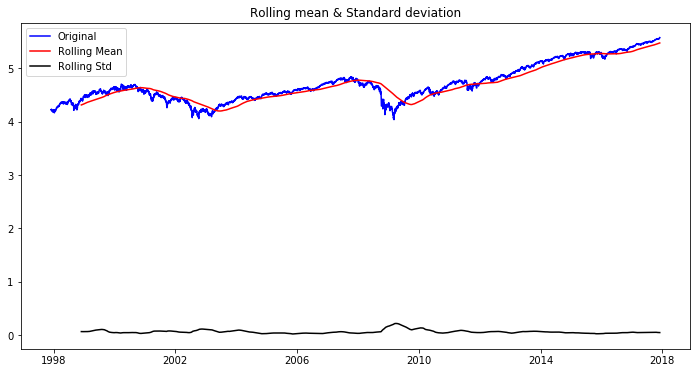

Results of Dickey Fuller Test:
Test Statistic                   -0.106512
p-value                           0.948786
#Lags Used                       26.000000
Number of Observations Used    7279.000000
Critical Value (1%)              -3.431249
Critical Value (5%)              -2.861937
Critical Value (10%)             -2.566981
dtype: float64


In [21]:
adf_test(indexed_dataset_logscale)

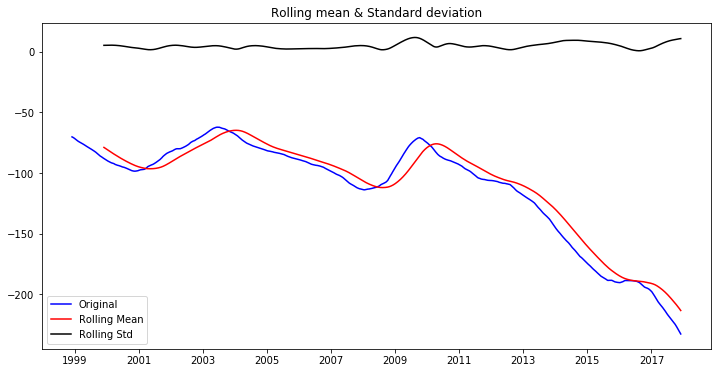

Results of Dickey Fuller Test:
Test Statistic                    0.819333
p-value                           0.991942
#Lags Used                       26.000000
Number of Observations Used    6915.000000
Critical Value (1%)              -3.431296
Critical Value (5%)              -2.861958
Critical Value (10%)             -2.566993
dtype: float64


In [22]:
# now we use logscale - moving average. 
dataset_logscale_minus_moving_average = indexed_dataset_logscale - moving_average
dataset_logscale_minus_moving_average.dropna(inplace=True)
adf_test(dataset_logscale_minus_moving_average)

We then check for exponential decay of the data.

This is a process to see the trend present within the time series.

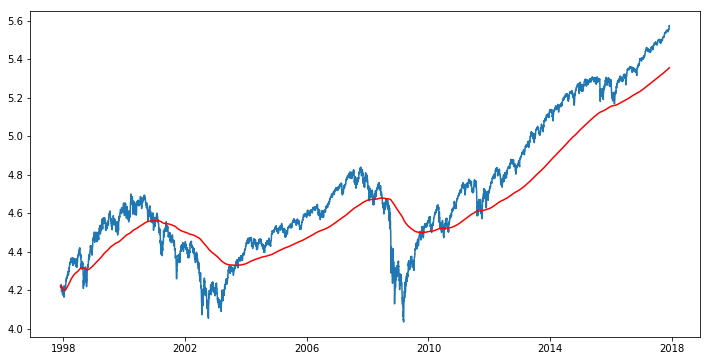

In [23]:
exponential_decay_weighted_average = indexed_dataset_logscale.ewm(halflife=365, min_periods=0, adjust=True).mean()
plt.plot(indexed_dataset_logscale)
plt.plot(exponential_decay_weighted_average, color='red')

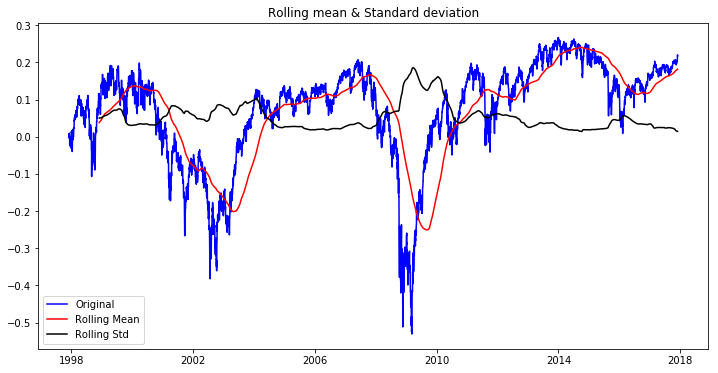

Results of Dickey Fuller Test:
Test Statistic                   -2.579770
p-value                           0.097251
#Lags Used                       26.000000
Number of Observations Used    7279.000000
Critical Value (1%)              -3.431249
Critical Value (5%)              -2.861937
Critical Value (10%)             -2.566981
dtype: float64


In [24]:
# to cover all bases, so I also compute the differences
dataset_logscale_minus_exponential_moving_average = indexed_dataset_logscale - exponential_decay_weighted_average
adf_test(dataset_logscale_minus_exponential_moving_average)

We shift the time series.

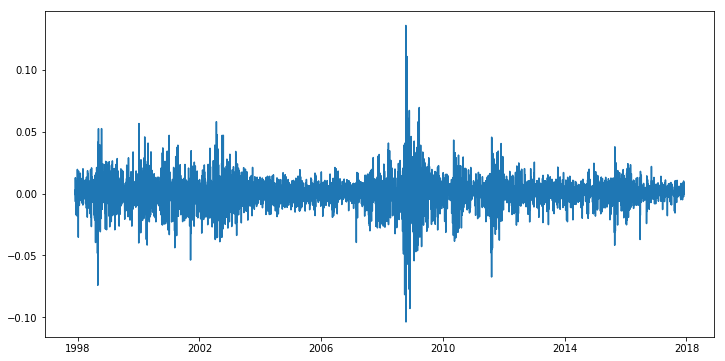

In [25]:
dataset_log_diff_shifting = indexed_dataset_logscale - indexed_dataset_logscale.shift()
plt.plot(dataset_log_diff_shifting)

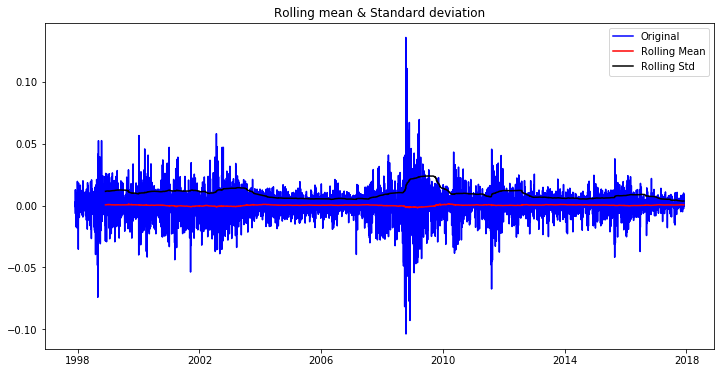

Results of Dickey Fuller Test:
Test Statistic                -1.716515e+01
p-value                        6.800882e-30
#Lags Used                     2.500000e+01
Number of Observations Used    7.279000e+03
Critical Value (1%)           -3.431249e+00
Critical Value (5%)           -2.861937e+00
Critical Value (10%)          -2.566981e+00
dtype: float64


In [26]:
dataset_log_diff_shifting.dropna(inplace=True)
adf_test(dataset_log_diff_shifting)

With the results of the Dickey Fuller Test we can see that the test statistic is lower than the critical value, and the p-value is significantly lower. 

**Thus we conclude now that the data is stationary**.

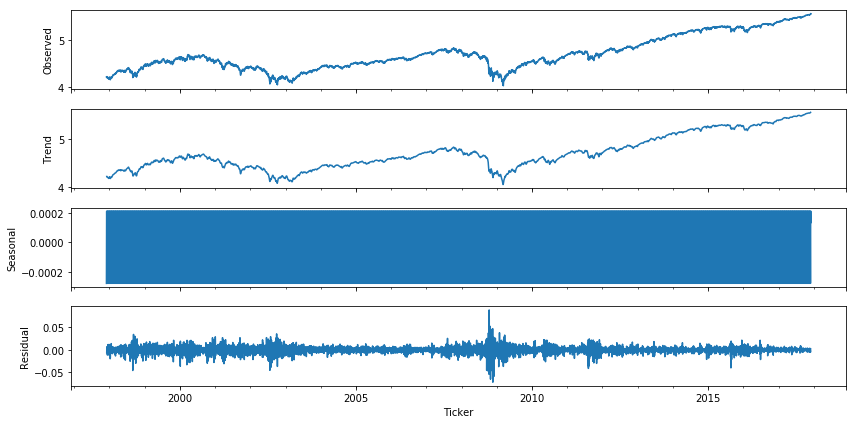

In [27]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(indexed_dataset_logscale, model='additive')
fig = decomposition.plot()
plt.show()

From the decomposition above, we see that there are trends but no seasonality and there is residual data.

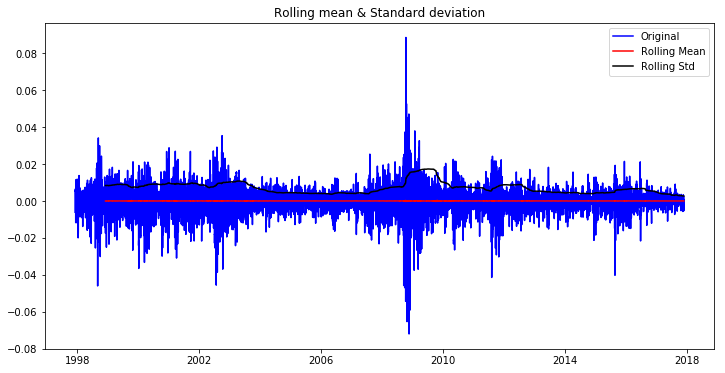

Results of Dickey Fuller Test:
Test Statistic                  -24.961692
p-value                           0.000000
#Lags Used                       36.000000
Number of Observations Used    7263.000000
Critical Value (1%)              -3.431251
Critical Value (5%)              -2.861938
Critical Value (10%)             -2.566982
dtype: float64


In [28]:
residual = decomposition.resid
decomposed_log_data = residual
decomposed_log_data.dropna(inplace=True)
adf_test(decomposed_log_data)

## ACF and PACF Plots

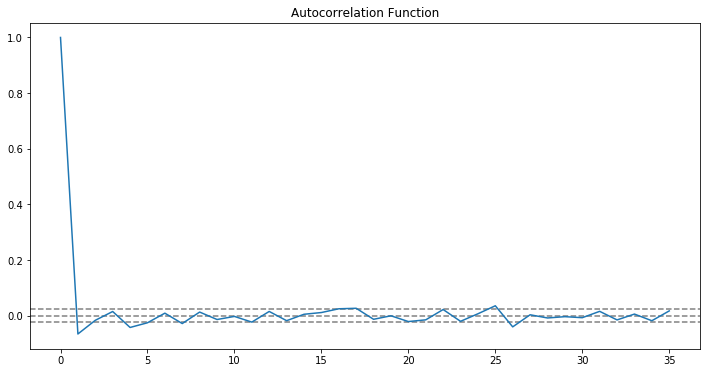

In [29]:
lag_acf = acf(dataset_log_diff_shifting.values, nlags=35)
lag_pacf = pacf(dataset_log_diff_shifting.values, nlags = 35, method='ols')

plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dataset_log_diff_shifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(dataset_log_diff_shifting)), linestyle='--', color='gray')

plt.plot(lag_acf)
plt.title('Autocorrelation Function')            

import warnings   
warnings.filterwarnings("ignore")
# warning sign shows you the unsupported functionality of mpld3

Text(0.5,1,'Partial Autocorrelation Function')

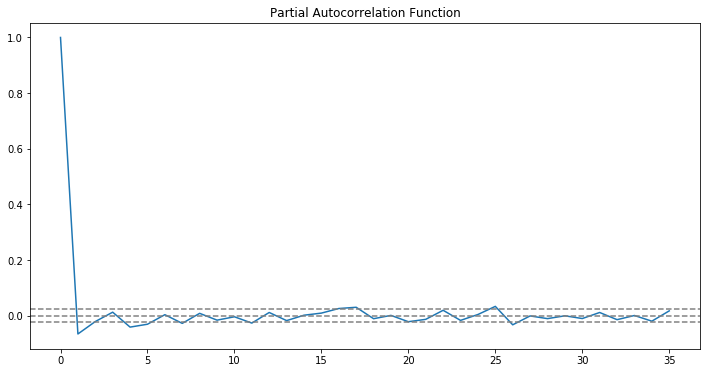

In [30]:
#Plot PACF
plt.plot(lag_pacf)

plt.axhline(y=abs(0), linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dataset_log_diff_shifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(dataset_log_diff_shifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

## The ordering of pdq

Even with having the values of pdq, to find the optimal pdq order with the lowest aic value, there is a code in r called auto.arima().
In python, there is a similar function but given the data and the time it consumes to load all AIC, it's highly unlikely. From this momen the calculations move from the assumptions that order is 1,1,1. I will try different orders and values in the model but only at minimal numbers. 


Note: The lower the RSA value, the better your order is.
The computer will give you an error when your p,d,q values are outside the stationarity of the data. 

 

## Creating the model the AR + I + MA = ARIMA

Plotting AR model


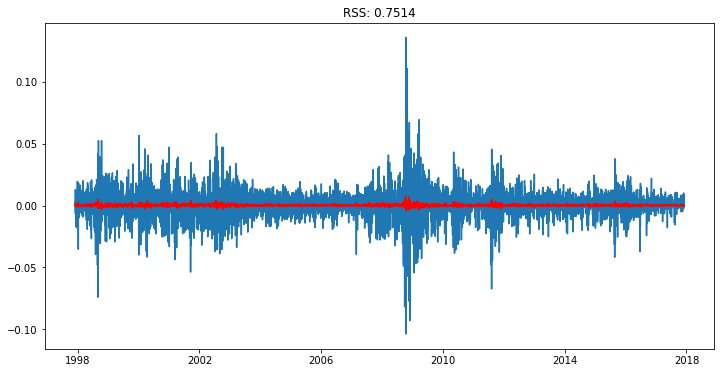

In [31]:
# AR model
model = ARIMA(indexed_dataset_logscale, order=(1,1,1))
results_AR = model.fit(disp=-1)
plt.plot(dataset_log_diff_shifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - dataset_log_diff_shifting['SPY'])**2))
print('Plotting AR model')

Plotting MA model


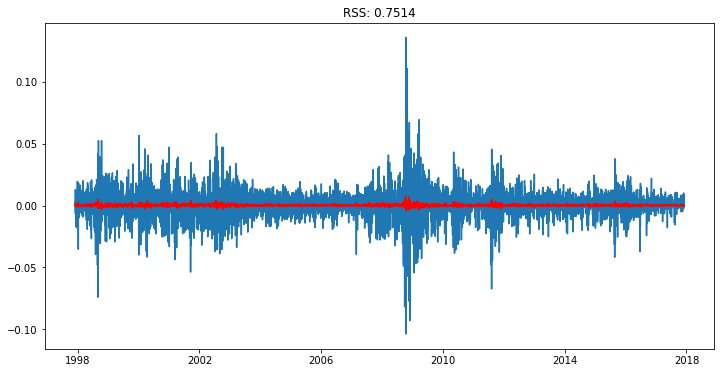

In [32]:
# MA model
model = ARIMA(indexed_dataset_logscale, order=(1,1,1))
results_MA = model.fit(disp=-1)
plt.plot(dataset_log_diff_shifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - dataset_log_diff_shifting['SPY'])**2))
print('Plotting MA model')

Plotting ARIMA model


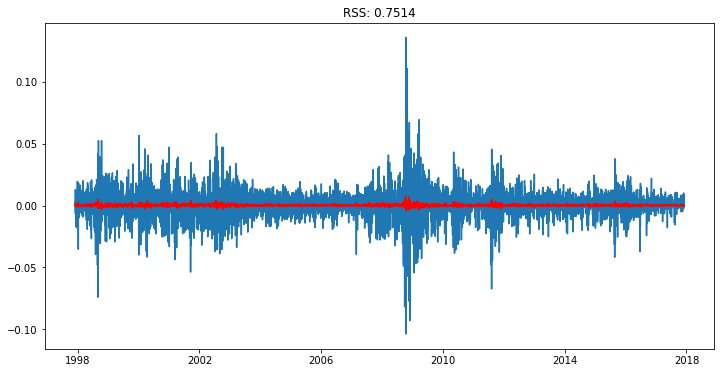

In [33]:
# AR+I+MA = ARIMA model
model = ARIMA(indexed_dataset_logscale, order=(1,1,1))
results_ARIMA = model.fit(disp=-1)
plt.plot(dataset_log_diff_shifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - dataset_log_diff_shifting['SPY'])**2))
print('Plotting ARIMA model')

Graph shows all the fitted values in the ARIMA model versus the observed values of the differentiated time shifted data.

## We reverse the process so that the values are now in scale at the original data.

In [34]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Ticker
1997-12-02    0.000185
1997-12-03    0.000494
1997-12-04    0.000269
1997-12-05    0.000305
1997-12-06   -0.000387
dtype: float64


In [35]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Ticker
1997-12-02    0.000185
1997-12-03    0.000679
1997-12-04    0.000948
1997-12-05    0.001254
1997-12-06    0.000866
dtype: float64


In [36]:
predictions_ARIMA_log = pd.Series(indexed_dataset_logscale['SPY'].iloc[0], index=indexed_dataset_logscale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Ticker
1997-12-01    4.221116
1997-12-02    4.221301
1997-12-03    4.221795
1997-12-04    4.222064
1997-12-05    4.222369
dtype: float64

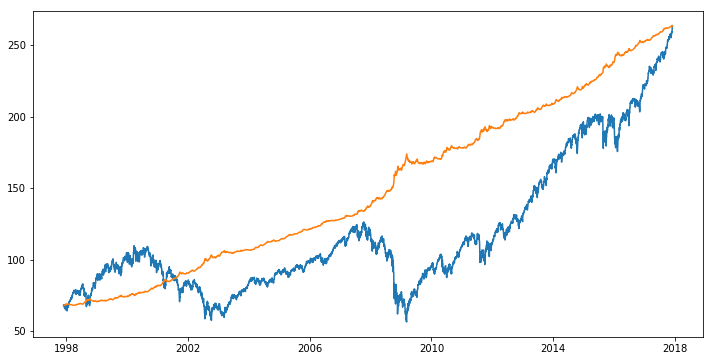

In [37]:
# Inverse of log is exp. We revert back to scaling so that we could have similar values in the original dataset
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexed_dataset)
plt.plot(predictions_ARIMA)

Knowing that there are 7308 rows of data, we predict 692 days on where the values could go from here.

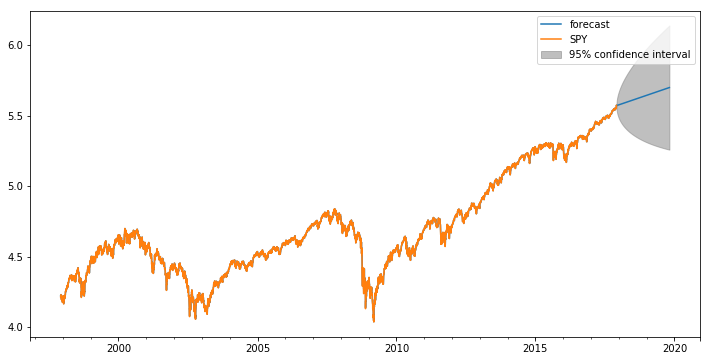

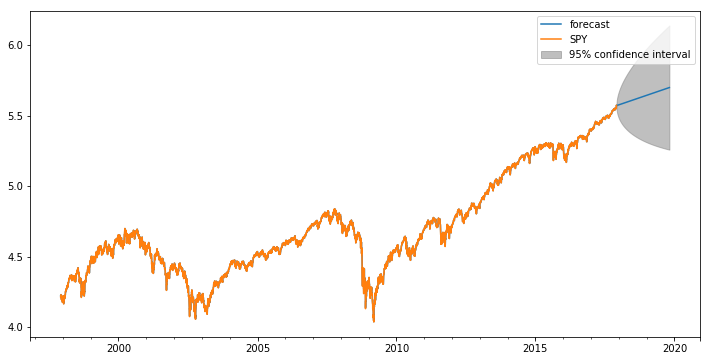

In [38]:
# We provide a forecast with 95% confidence interval and the possible values as forecast.
results_ARIMA.plot_predict(1,8000)

In [39]:
# Now the date tomorrow is 09/09/2018
# Days from the last dataset is exactly 282 days

future = results_ARIMA.forecast(steps=282)
np.exp(future[0:1])

array([[263.06073932, 263.04082124, 263.04367826, 263.06174468,
        263.08997027, 263.12498326, 263.16453219, 263.20711352,
        263.25172315, 263.29769046, 263.34456757, 263.39205533,
        263.43995395, 263.48812997, 263.53649427, 263.58498731,
        263.63356935, 263.68221381, 263.73090297, 263.77962497,
        263.82837191, 263.8771385 , 263.92592121, 263.97471769,
        264.02352636, 264.07234618, 264.12117643, 264.17001666,
        264.21886656, 264.2677259 , 264.31659457, 264.36547246,
        264.41435951, 264.46325569, 264.51216096, 264.56107532,
        264.60999875, 264.65893124, 264.70787279, 264.7568234 ,
        264.80578307, 264.85475179, 264.90372957, 264.95271641,
        265.00171231, 265.05071727, 265.09973129, 265.14875438,
        265.19778653, 265.24682775, 265.29587804, 265.3449374 ,
        265.39400583, 265.44308334, 265.49216992, 265.54126558,
        265.59037031, 265.63948413, 265.68860703, 265.73773902,
        265.78688009, 265.83603024, 265.

This is the forecasted price as of 09/09/2018 - 276.87303157.

There are many ways to improve this, but it will take longer. Better documentations of processes done.

Thanks for reading